raw image size:  (733, 512, 512)
(1, 512, 512)
1
(1, 48, 48) label:  0
1
(1, 48, 48) label:  0
1
(1, 48, 48) label:  0
1
(1, 48, 48) label:  0
1
(1, 48, 48) label:  0
1
(1, 48, 48) label:  1
1
(1, 48, 48) label:  1
1
(1, 48, 48) label:  1
1
raw image size:  (133, 512, 512)
(1, 512, 512)
1
(1, 48, 48) label:  1
1
raw image size:  (183, 512, 512)
(1, 512, 512)
1
raw image size:  (195, 512, 512)
(1, 512, 512)
1
(1, 48, 48) label:  1
1


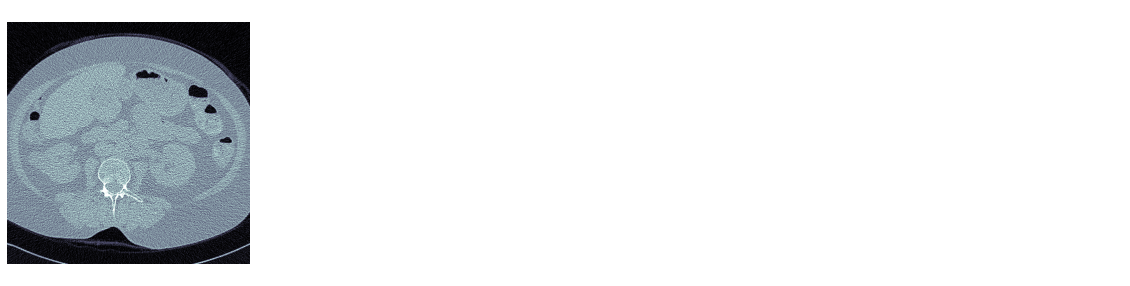

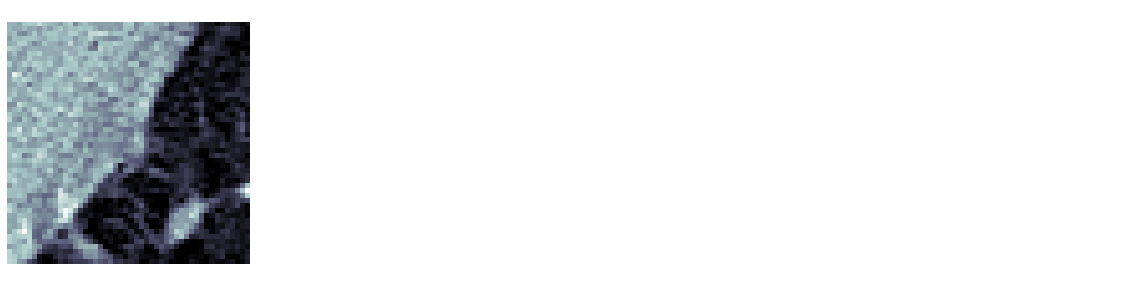

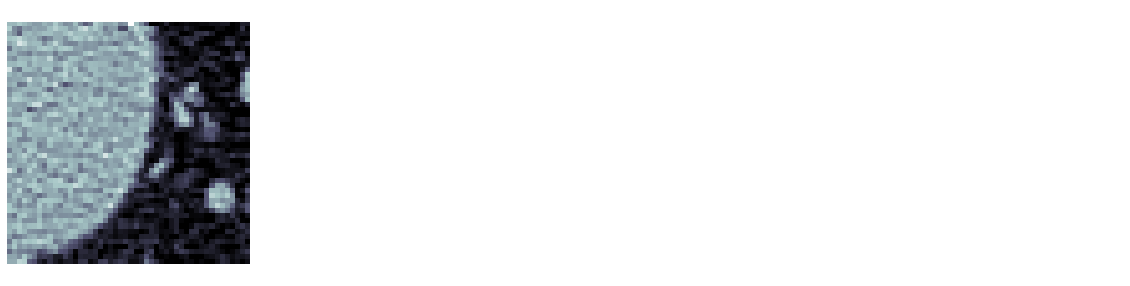

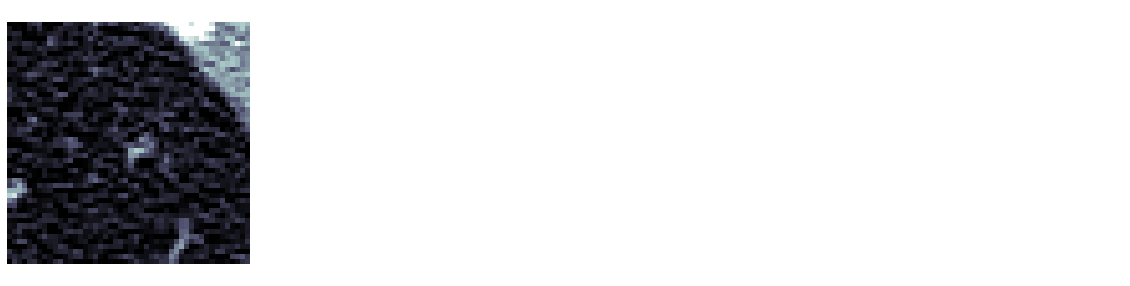

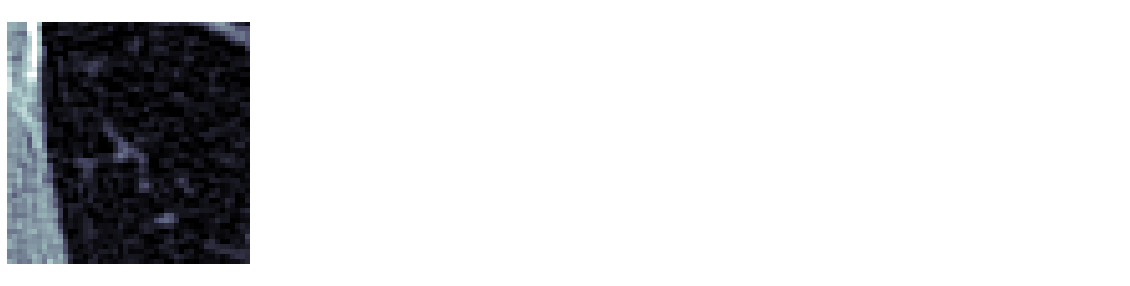

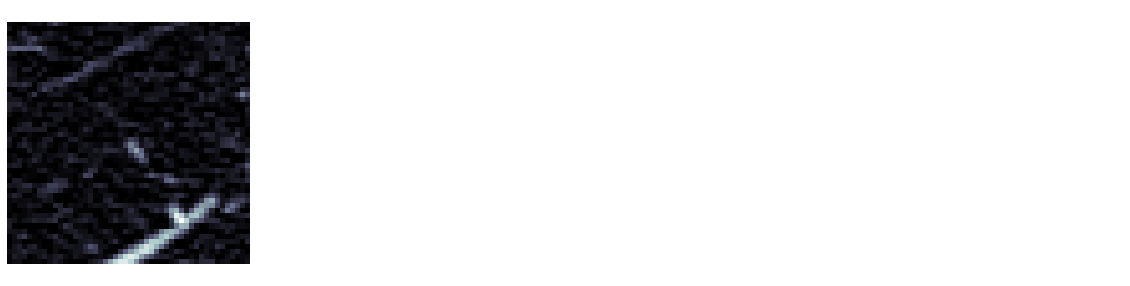

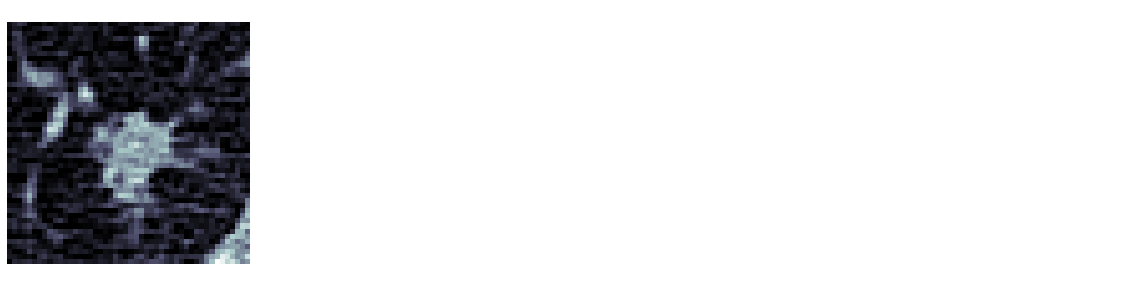

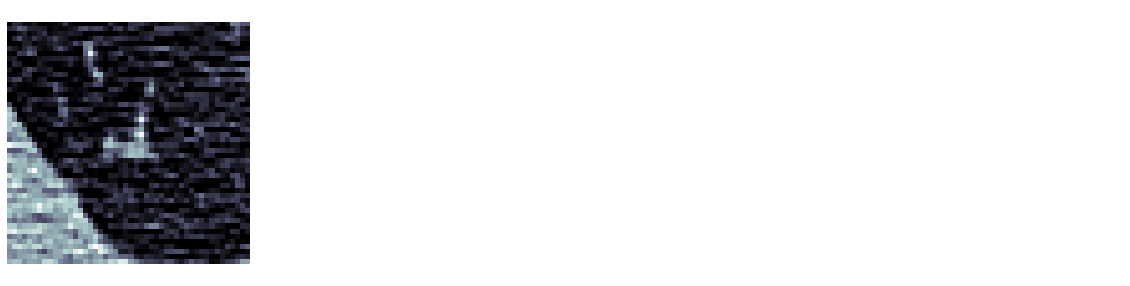

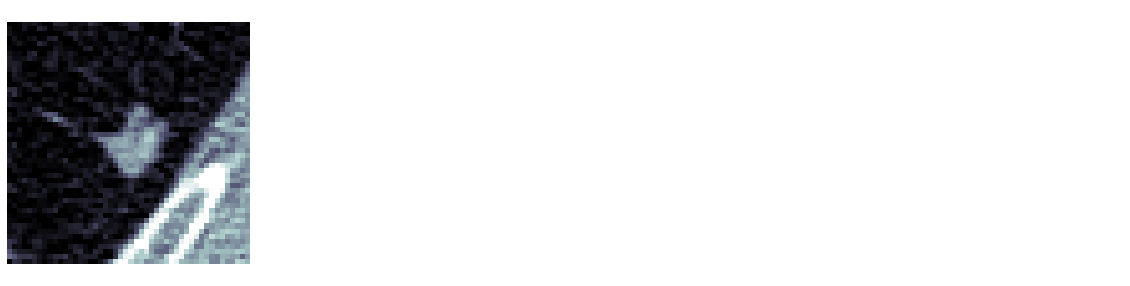

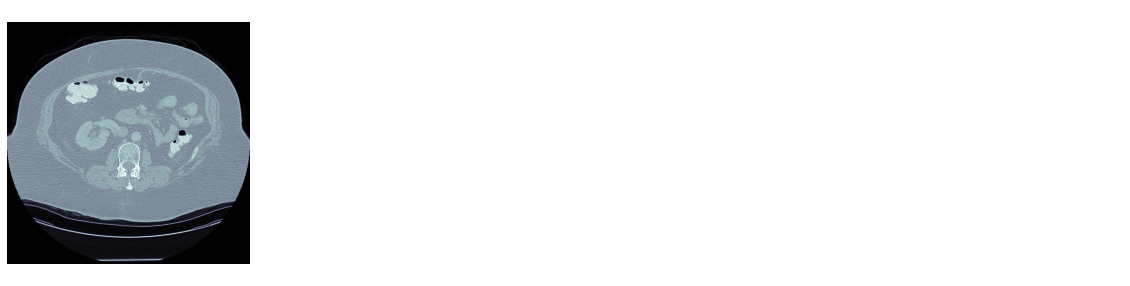

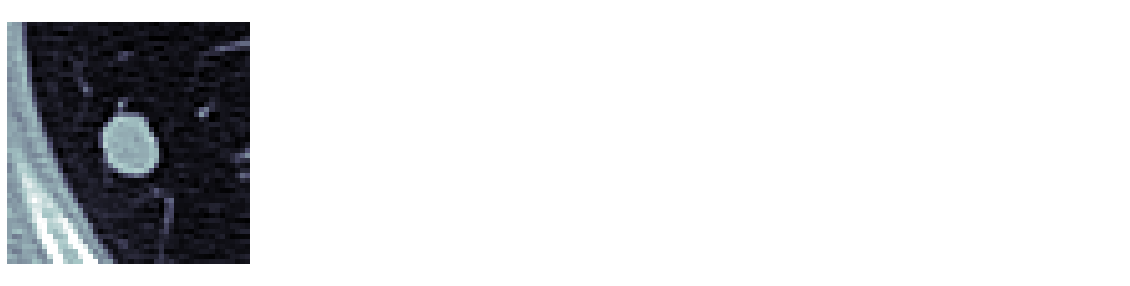

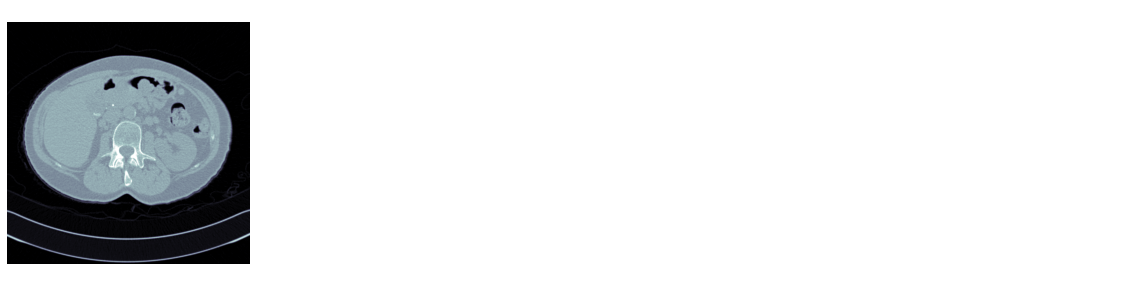

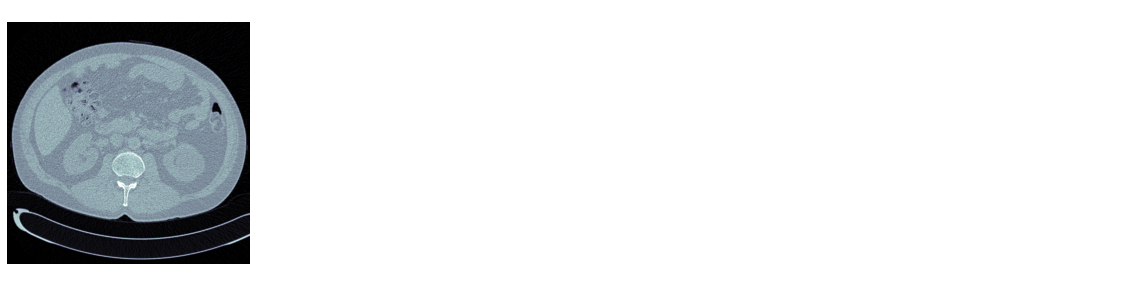

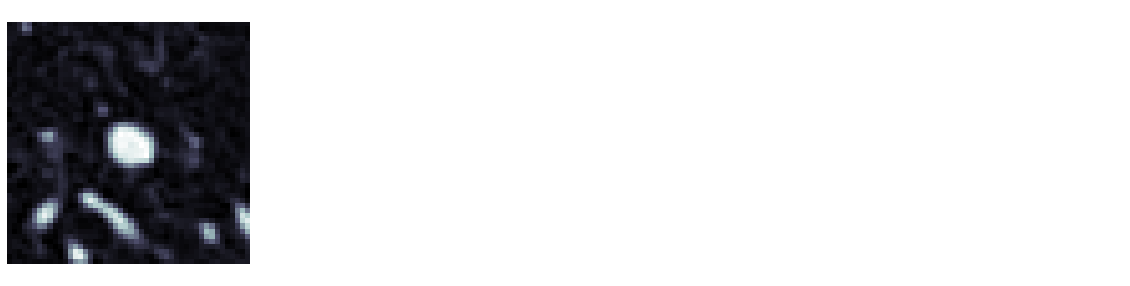

In [1]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
tqdm = lambda x: x


def load_itkfilewithtrucation(filename, upper=200, lower=-200):
    """
    load mhd files,set truncted value range and normalization 0-255
    :param filename:
    :param upper:
    :param lower:
    :return:
    """

    # 1,tructed outside of liver value
    srcitkimage = sitk.Cast(sitk.ReadImage(filename), sitk.sitkFloat32)
    srcitkimagearray = sitk.GetArrayFromImage(srcitkimage)
    print('raw image size: ', srcitkimagearray.shape)
    srcitkimagearray[srcitkimagearray > upper] = upper
    srcitkimagearray[srcitkimagearray < lower] = lower
    # 2,get tructed outside of liver value image
    sitktructedimage = sitk.GetImageFromArray(srcitkimagearray)
    origin = np.array(srcitkimage.GetOrigin())
    spacing = np.array(srcitkimage.GetSpacing())
    sitktructedimage.SetSpacing(spacing)
    sitktructedimage.SetOrigin(origin)
    # 3 normalization value to 0-255
    rescalFilt = sitk.RescaleIntensityImageFilter()
    rescalFilt.SetOutputMaximum(255)
    rescalFilt.SetOutputMinimum(0)
    itkimage = rescalFilt.Execute(sitk.Cast(sitktructedimage, sitk.sitkFloat32))
    return itkimage

def get_2d_ROI_from_img(img3d,center,block_size):
    center_z = center[0]
    center_y = center[1]
    center_x = center[2]
    start_x = max(center_x - block_size / 2, 0)
    if start_x + block_size > img3d.shape[2]:
        start_x = img3d.shape[2] - block_size
    start_y = max(center_y - block_size / 2, 0)
    if start_y + block_size > img3d.shape[1]:
        start_y = img3d.shape[1] - block_size

    # start_z = max(center_z - block_size / 2, 0)
    # if start_z + block_size > img3d.shape[0]:
    #     start_z = img3d.shape[0] - block_size

    center_z = int(center_z)
    start_y = int(start_y)
    start_x = int(start_x)
    roi_img2d = img3d[center_z:center_z+1, start_y:start_y + block_size, start_x:start_x + block_size]
    return roi_img2d

# Some helper functions

def get_cube_from_img(img3d, center, block_size):
    # get roi(z,y,z) image and in order the out of img3d(z,y,x)range
    center_z = center[0]
    center_y = center[1]
    center_x = center[2]
    start_x = max(center_x - block_size / 2, 0)
    if start_x + block_size > img3d.shape[2]:
        start_x = img3d.shape[2] - block_size
    start_y = max(center_y - block_size / 2, 0)
    if start_y + block_size > img3d.shape[1]:
        start_y = img3d.shape[1] - block_size
    start_z = max(center_z - block_size / 2, 0)
    if start_z + block_size > img3d.shape[0]:
        start_z = img3d.shape[0] - block_size
    start_z = int(start_z)
    start_y = int(start_y)
    start_x = int(start_x)
    roi_img3d = img3d[start_z:start_z + block_size, start_y:start_y + block_size, start_x:start_x + block_size]
    return roi_img3d


# Helper function to get rows in data frame associated
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return (f)


def get_node_classify():
    # Getting list of image files and output nuddle 0 and 1
    for subsetindex in range(10):
        classify_size = 48
        luna_path = "/Volumes/Secrets/Research_DAE/LUNA16-Lung-Nodule-Analysis-2016-Challenge-master/LUNA16Challege/data/luna_raw/"
        luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
        output_path = "/Volumes/Secrets/Research_DAE/LUNA16-Lung-Nodule-Analysis-2016-Challenge-master/LUNA16Challege/data/classification/"
        file_list = glob(luna_subset_path + "*.mhd")
        
        file_list_path=[]
        for i in range(len(file_list)):
            file_list_path.append(file_list[i][0:-4])
        

        # The locations of the nodes
        luna_csv_path = "/Volumes/Secrets/Research_DAE/LUNA16-Lung-Nodule-Analysis-2016-Challenge-master/LUNA16Challege/data"
        df_node = pd.read_csv(luna_csv_path + "/CSVFILES/" + "candidates_V2.csv")
        df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list_path, file_name))
        df_node = df_node.dropna()
        

        max_num = 5
        pos_num = 0
        neg_num = 0
        # start = True
        # Looping over the image files
        for fcount, img_file in enumerate(tqdm(file_list)):
            # get all nodules associate with file
            img_file = img_file[0:-4]
            mini_df = df_node[df_node["file"] == img_file]
            # some files may not have a nodule--skipping those
            if mini_df.shape[0] > 0:
            #     if start == False:
            #         return 
            #     else :
            #         start = False
                img_file=img_file+".mhd"
                # load the data once
                itk_img = load_itkfilewithtrucation(img_file, 600, -1000)
                img_array = sitk.GetArrayFromImage(itk_img)
                def plot_ct_scan(scan, num_column=4, jump=1):
                    num_slices = len(scan)
                    print(num_slices)
                    num_row = (num_slices//jump + num_column - 1) // num_column
                    f, plots = plt.subplots(num_row, num_column, figsize=(num_column*5, num_row*5))
                    for i in range(0, num_row*num_column):
                        plot = plots[i % num_column] if num_row == 1 else plots[i // num_column, i % num_column]        
                        plot.axis('off')
                        if i < num_slices//jump:
                            plot.imshow(scan[i*jump], cmap=plt.cm.bone) 

                print(img_array[:1].shape)
                plot_ct_scan(img_array[:1])




                # x,y,z  Origin in world coordinates (mm)
                origin = np.array(itk_img.GetOrigin())
                # spacing of voxels in world coor. (mm)
                spacing = np.array(itk_img.GetSpacing())
                # go through all nodes

                for node_idx, cur_row in mini_df.iterrows():
                    
                    node_x = cur_row["coordX"]
                    node_y = cur_row["coordY"]
                    node_z = cur_row["coordZ"]
                    label = cur_row["class"]

                    if pos_num >= max_num and neg_num >= max_num:
                        return 
                    if label == 1:
                        if pos_num >= max_num:
                            continue
                    elif label == 0:
                        if neg_num >= max_num:
                            continue
                    

                    # nodule center
                    center = np.array([node_x, node_y, node_z])
                    # nodule center in voxel space (still x,y,z ordering)  # clip prevents going out of bounds in Z
                    v_center = np.rint((center - origin) / spacing)
                    # convert x,y,z order v_center to z,y,z order v_center
                    v_center[0], v_center[1], v_center[2] = v_center[2], v_center[1], v_center[0]
                    # get cub size of classify_size
                    node_cube = get_cube_from_img(img_array, v_center, classify_size)
                    node_cube.astype(np.uint8)

                    node_roi2d = get_2d_ROI_from_img(img_array, v_center, classify_size)
                    node_roi2d.astype(np.uint8)

                    print(node_roi2d.shape, 'label: ',label)
                    plot_ct_scan(node_roi2d)

                    

                    
                    if label == 1:
                        filepath = output_path + "1/"
                        if not os.path.exists(filepath):
                            os.makedirs(filepath)
                        cv2.imwrite(filepath + str(pos_num) + ".bmp", node_roi2d[0])
                        pos_num += 1
                    if label == 0:
                        filepath = output_path + "0/"
                        if not os.path.exists(filepath):
                            os.makedirs(filepath)
                        cv2.imwrite(filepath + str(neg_num) + ".bmp", node_roi2d[0])
                        neg_num += 1

                    # save as bmp file
                    # for i in range(classify_size):
                    #     if label == 1:
                    #         filepath = output_path + "1/" + str(subsetindex) + "_" + str(fcount) + "_" + str(index) + "/"
                    #         if not os.path.exists(filepath):
                    #             os.makedirs(filepath)
                    #         cv2.imwrite(filepath + str(i) + ".bmp", node_cube[i])
                    #     if label == 0:
                    #         filepath = output_path + "0/" + str(subsetindex) + "_" + str(fcount) + "_" + str(index) + "/"
                    #         if not os.path.exists(filepath):
                    #             os.makedirs(filepath)
                    #         cv2.imwrite(filepath + str(i) + ".bmp", node_cube[i])
                    # index += 1


                    # save as npy file

                    # if label == 1:
                    #     filepath = output_path + "1/"
                    #     if not os.path.exists(filepath):
                    #         os.makedirs(filepath)
                    #     filename = str(subsetindex) + "_" + str(fcount) + "_" + str(index)
                    #     np.save(filepath + filename + ".npy", node_cube)
                    # if label == 0:
                    #     filepath = output_path + "0/"
                    #     if not os.path.exists(filepath):
                    #         os.makedirs(filepath)
                    #     filename = str(subsetindex) + "_" + str(fcount) + "_" + str(index)
                    #     np.save(filepath + filename + ".npy", node_cube)
                    # index += 1


get_node_classify()

